# Variational Autoencoder

Following several tutorials as listed below
https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b

Something I didn't realise initially was the difference between Variational Autoencoders and straight Autoencoders. As it so happens there is quite a large and destinct difference which relates fundamentally to whether the models are generative (variational) or discriminative (straight). Generative models appear to be more powerful than straight descriminative models but with that power comes additional complexities.

In this first foray into generative models below I will hopefully learn to understand the difference and the benefits of such models.


## Pytorch Implementation

Using pytorch and the mnist dataset we will code this up.

Import everything:

In [25]:
!pip install lightning-bolts

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pl_bolts.models.autoencoders import VAE
from pl_bolts.datamodules import CIFAR10DataModule

Defaulting to user installation because normal site-packages is not writeable


Lets use weights and biases. You will need an account.
If running this on a cluster with jupyter nbconvert then get rid of all wandb code as you are unable to sign in as below.
There is probably a way around this that I haven't researched.

In [44]:
import wandb

Edit the below cell to setup project global variables

In [40]:
vae = VAE(input_height=32)
print(VAE.pretrained_weights_available())
vae = vae.from_pretrained('cifar10-resnet18')

vae.freeze()

dm = CIFAR10DataModule(data_dir="data", batch_size=4)
dm.setup()
dm.prepare_data()

data_loader = dm.val_dataloader()

for x, y in data_loader:
    print(x.shape)
    x = torch.reshape(x,[4,3,32,32])
    image = vae(x)
    break


['cifar10-resnet18', 'stl10-resnet18']
Files already downloaded and verified
Files already downloaded and verified
torch.Size([4, 3, 32, 32])


Now, lets set up our MNIST dataset. This is a simple setup and uses built in functions that can be found almost line-for-line in the quickstart guide

In [33]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, 32, shuffle=True)
test_dataloader = DataLoader(test_data, 32)

#Printing data
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Files already downloaded and verified
Files already downloaded and verified
Shape of X [N, C, H, W]:  torch.Size([32, 3, 32, 32])
Shape of y:  torch.Size([32]) torch.int64
torch.Size([3, 32, 32])


Now that we have this class we can go about training the network.

Training and testing datasets

['cifar10-resnet18', 'stl10-resnet18']


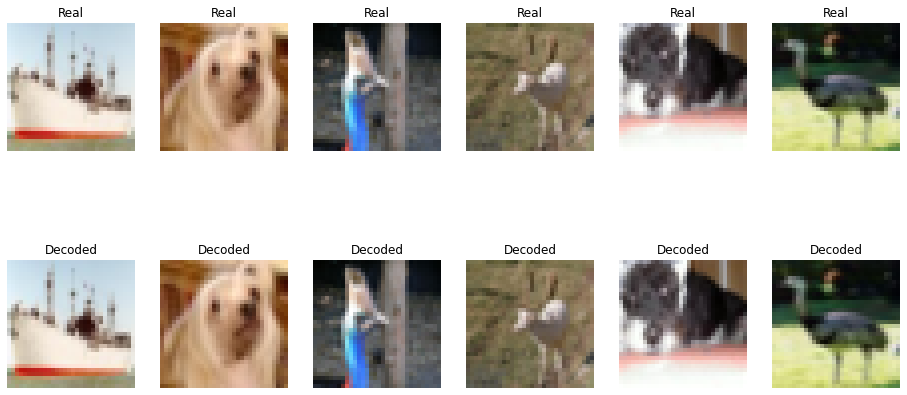

wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


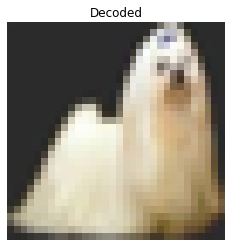

[['Real', <wandb.sdk.data_types.Image object at 0x7f65ec35b460>], ['Decoded', <wandb.sdk.data_types.Image object at 0x7f65e80f6370>], ['Real', <wandb.sdk.data_types.Image object at 0x7f65ec38eb50>], ['Decoded', <wandb.sdk.data_types.Image object at 0x7f65ef3ff8b0>], ['Real', <wandb.sdk.data_types.Image object at 0x7f65eb6e77f0>], ['Decoded', <wandb.sdk.data_types.Image object at 0x7f65ebff1850>], ['Real', <wandb.sdk.data_types.Image object at 0x7f65f44a4580>], ['Decoded', <wandb.sdk.data_types.Image object at 0x7f65ef1e9d90>], ['Real', <wandb.sdk.data_types.Image object at 0x7f65ef256940>], ['Decoded', <wandb.sdk.data_types.Image object at 0x7f65e8284730>], ['Real', <wandb.sdk.data_types.Image object at 0x7f65e80181f0>], ['Decoded', <wandb.sdk.data_types.Image object at 0x7f65e8045a00>]]


In [55]:
figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 2

vae = VAE(input_height=32)
print(VAE.pretrained_weights_available())
vae = vae.from_pretrained('cifar10-resnet18')

vae.freeze()

for i in range(1, cols +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    image = torch.reshape(img,[1,3,32,32])
    pred = vae(image)
    pred = torch.reshape(img,[32,32,3])
    pred = pred.to("cpu")
    pred = pred.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title("Real")
    plt.axis("off")
    plt.imshow(img.reshape(3,32,32).permute(1, 2, 0))
    figure.add_subplot(rows, cols, i+cols)
    plt.title("Decoded")
    plt.axis("off")
    plt.imshow(pred.reshape(3,32,32).transpose(1, 2, 0))
plt.show()

wandb.init(project="VariationalAutoencoder-pretrained",
           config={
           })

my_data = []

for i in range(1, cols +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    my_data.append(["Real", wandb.Image(img)])
    image = torch.reshape(img,[1,3,32,32])
    pred = vae(image)
    pred = torch.reshape(img,[32,32,3])
    pred = pred.to("cpu")
    pred = pred.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title("Real")
    plt.axis("off")
    plt.imshow(img.reshape(3,32,32).permute(1, 2, 0))
    figure.add_subplot(rows, cols, i+cols)
    plt.title("Decoded")
    plt.axis("off")
    plt.imshow(pred.reshape(3,32,32).transpose(1, 2, 0))
    my_data.append(["Decoded", wandb.Image(pred.reshape(3,32,32).transpose(1, 2, 0))])
plt.show()

print(my_data)

columns=["id", "image"]
test_table = wandb.Table(data=my_data, columns=columns)
wandb.log({"table_key": test_table})


  

In [14]:

torch.save(model, 'model.pth')
torch.save(model.state_dict(), 'model_weights.pth')
